### Import libraries & data

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

In [3]:
test = pd.read_csv('datasets/test.csv', index_col=0)
train = pd.read_csv('datasets/train.csv', index_col=0)
train.shape, test.shape

((2051, 80), (878, 79))

In [4]:
test['SalePrice'] = np.nan      # create empty SalePrice column in test
train['dataset'] = 0            # id train data with dataset col = 0
test['dataset'] = 1             # id test data with dataset col = 0
df = pd.concat([test, train])   # concatenate
df.reset_index(inplace=True)    # get 'Id' col

In [5]:
df.drop(columns='PID', inplace=True)

#### Impute missing values

<div class="alert alert-warning">
Consider being more specific here . . .
</div>

In [6]:
# iterate through columns with Na values
for col in [c for c in df.columns if df[c].isna().sum() > 0]:
    if 'Garage Yr' in col:
        df[col] = df[col].fillna(df['Year Built'])   # 'Year Built' for na in 'Garage Yr'
    elif df[col].dtype == 'object':
        df[col] = df[col].fillna("None")             # 'none' for na in object columns
    else:
        df[col] = df[col].fillna(0)                  # 0 for na in numerical columns

---
## Cleaning & engineering

### A) Continuous features

In [7]:
continuous_x = ['Lot Frontage', 'Lot Area', 'Year Built', 'Year Remod/Add',
                'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
                'Mas Vnr Area', '1st Flr SF', '2nd Flr SF', 'Pool Area',
                'Low Qual Fin SF', 'Screen Porch', 'Gr Liv Area', 'Garage Yr Blt',
                'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
                '3Ssn Porch', 'Misc Val', 'TotRms AbvGrd', 'Yr Sold', 'Mo Sold']

In [8]:
# list by r to SalePrice in train
train.corr().loc['SalePrice', continuous_x].sort_values(ascending=False)

Gr Liv Area        0.697038
Garage Area        0.650270
Total Bsmt SF      0.628925
1st Flr SF         0.618486
Year Built         0.571849
Year Remod/Add     0.550370
Garage Yr Blt      0.533922
Mas Vnr Area       0.512230
TotRms AbvGrd      0.504014
BsmtFin SF 1       0.423519
Lot Frontage       0.341842
Open Porch SF      0.333476
Wood Deck SF       0.326490
Lot Area           0.296566
2nd Flr SF         0.248452
Bsmt Unf SF        0.190210
Screen Porch       0.134581
3Ssn Porch         0.048732
Mo Sold            0.032735
Pool Area          0.023106
BsmtFin SF 2       0.016255
Misc Val          -0.007375
Yr Sold           -0.015203
Low Qual Fin SF   -0.041594
Enclosed Porch    -0.135656
Name: SalePrice, dtype: float64

#### Dealing with weaker columns

In [9]:
# make year and month sold categorical
df[['Yr Sold', 'Mo Sold']] = df[['Yr Sold', 'Mo Sold']].astype('str')

# dummy zeros in 'Pool Area', BsmtFin SF 2', 'Bsmt Unf SF' & 'Low Qual Fin SF'
df['has_Pool'] = [1 if x >0 else 0 for x in df['Pool Area']]
df['has_BsFn2'] = [1 if x >0 else 0 for x in df['BsmtFin SF 2']]
df['has_BsUnf'] = [1 if x >0 else 0 for x in df['Bsmt Unf SF']]
df['has_LoQuFin'] = [1 if x > 0 else 0 for x in df['Low Qual Fin SF']]

# interact and sum porches
df['Total Porch'] = df['Open Porch SF']+df['Enclosed Porch']+df['3Ssn Porch']+df['Screen Porch']
df['Porch_inter'] = df['Open Porch SF']*df['Enclosed Porch']*df['3Ssn Porch']*df['Screen Porch']

# interact and sum SF
df['Total SF'] = df['Gr Liv Area'] + df['Total Bsmt SF'] + df['Total Porch'] + df['Garage Area']
df['SF_inter'] = df['Gr Liv Area']*df['Total Bsmt SF']*df['Total Porch']*df['Garage Area']

# dummy zeros in weaker porches 
df['has_EncPo'] = [1 if x > 0 else 0 for x in df['Enclosed Porch']]
df['has_ScrPo'] = [1 if x > 0 else 0 for x in df['Screen Porch']]
df['has_3SsPo'] = [1 if x > 0 else 0 for x in df['3Ssn Porch']]

# drop remaining variables with abs(r)<.2 to target
df.drop(columns=['Bsmt Unf SF', 'BsmtFin SF 2', 'Low Qual Fin SF',
                 'Screen Porch', '3Ssn Porch', 'Enclosed Porch',
                 'Pool Area', 'Misc Val', ], inplace=True)  # (** totally dropping misc val? **)

In [10]:
# replace typo with mean in Garage Yr Blt
print(f"Dropping {df['Garage Yr Blt'].max()}...")
df['Garage Yr Blt'].replace(df['Garage Yr Blt'].max(), df['Garage Yr Blt'].mean(), inplace=True)

Dropping 2207.0...


#### Log transform key continous x variables

In [11]:
x_to_log = ['Lot Area', 'Lot Frontage',  'Gr Liv Area',
            'BsmtFin SF 1', 'Total Bsmt SF', '1st Flr SF',
            'Total Porch', 'Open Porch SF', 'Wood Deck SF',
            'Mas Vnr Area', 'TotRms AbvGrd', ]
for x in x_to_log:
    df[x+'_log'] = (df[x]+1).apply(np.log)
    print('Log transformed', x)

Log transformed Lot Area
Log transformed Lot Frontage
Log transformed Gr Liv Area
Log transformed BsmtFin SF 1
Log transformed Total Bsmt SF
Log transformed 1st Flr SF
Log transformed Total Porch
Log transformed Open Porch SF
Log transformed Wood Deck SF
Log transformed Mas Vnr Area
Log transformed TotRms AbvGrd


---
### B) Ordinal Features

In [12]:
ordinal_x = ['BsmtFin Type 1', 'BsmtFin Type 2', 'Exter Qual', 'Exter Cond', 'Bsmt Cond', 
             'Bsmt Qual', 'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Qual',
             'Garage Cond', 'Pool QC', 'Lot Shape', 'Utilities', 'Land Slope', 'Bsmt Exposure',
             'Electrical', 'Functional', 'Garage Finish', 'Paved Drive', 'Fence', 'Overall Qual',
             'Overall Cond', 'Mo Sold', ]

Before getting r to Saleprice, ordinals must be encoded:

In [13]:
# standard ordinal scale:
standard_mapper =  {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None':0}
standard_cols = ['Exter Qual', 'Exter Cond', 'Bsmt Cond', 'Bsmt Qual',
               'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Qual',
               'Garage Cond', 'Pool QC']
for col in standard_cols:
    df[col] = df[col].replace(standard_mapper).astype('float')

In [14]:
# basement ordinals:
bsmt_mapper =  { 'None': 0, 'Unf': 0, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6, }
bsmt_cols = ['BsmtFin Type 1', 'BsmtFin Type 2']
for col in bsmt_cols:
    df[col] = df[col].replace(bsmt_mapper).astype('float')

In [15]:
# unique ordinals:
unique_ords = {
    'Lot Shape': { 'None': 0, 'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3, },
    'Utilities': { 'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1, 'None': 0, },
    'Land Slope': { 'None': 0, 'Gtl': 0, 'Mod': 1, 'Sev': 2, },
    'Bsmt Exposure': { 'Gd': 5, 'Av': 3, 'Mn': 2, 'No': 0, 'None': 0, },
    'Electrical': { 'SBrkr': 4, 'FuseA': 3, 'FuseF': 2, 'FuseP': 1, 'Mix': 4, 'None': 0, },
    'Functional': { 'None': 0, 'Typ': 0, 'Min1': 2, 'Min2': 3, 'Mod': 4, 'Maj1': 6, 'Maj2': 7, 'Sev': 8, 'Sal': 10, },
    'Garage Finish': { 'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0, },
    'Paved Drive': { 'Y': 3, 'P': 2, 'N': 1, 'None': 0, },
    'Fence': { 'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0, },}
for col, mapper in unique_ords.items():
    df[col] = df[col].replace(mapper).astype('float')

In [16]:
# list by r to SalePrice in train
df[df['dataset']==0].corr().loc['SalePrice', ordinal_x].sort_values(ascending=False)

/Users/jfitz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


Overall Qual      0.800207
Exter Qual        0.712146
Kitchen Qual      0.692336
Bsmt Qual         0.612188
Garage Finish     0.557839
Fireplace Qu      0.538925
Heating QC        0.458354
Bsmt Exposure     0.417279
BsmtFin Type 1    0.321022
Lot Shape         0.294542
Paved Drive       0.290472
Garage Qual       0.285281
Garage Cond       0.265021
Electrical        0.246507
Bsmt Cond         0.225075
Land Slope        0.057990
Exter Cond        0.036418
Pool QC           0.029275
Utilities         0.026404
BsmtFin Type 2   -0.022096
Overall Cond     -0.097019
Functional       -0.126927
Fence            -0.159060
Mo Sold                NaN
Name: SalePrice, dtype: float64

<div class='alert alert-success'>
Use this graphic to explain binarizing
</div>

Text(0.5, 0, 'BsmtFin Type 2')

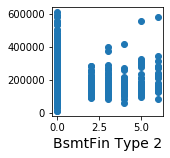

In [17]:
plt.figure(figsize=(2,2))
plt.scatter(df[df['dataset']==0]['BsmtFin Type 2'], df[df['dataset']==0]['SalePrice']);
plt.xlabel('BsmtFin Type 2', fontsize=14)

In [18]:
# binarize 'Electrical', 'Paved Drive', 'BsmtFin Type 2' and 'Overall Cond'
df['Electrical'] = [1 if x == 4 else 0 for x in df['Electrical']]         # has SBrkr or not(else)
df['Paved Drive'] = [1 if x == 3 else 0 for x in df['Paved Drive']]        # has paved drive or not(Partial/No)
df['Overall Cond'] = [1 if x >= 5 else 0 for x in df['Overall Cond']]    # >=5 overall cond or <5 
df['BsmtFin Type 2'] = [1 if x == 3 else 0 for x in df['BsmtFin Type 2']] # has BsFin T2 or not(None/Unf)

# drop columns with >99% values in one category
df.drop(columns=['Pool QC', 'Utilities',], inplace=True)

Some ordinals lend themselves better than others to encoding:

In [19]:
# treat as categorical and ordinal:
cat_plus_ord = ['Overall Qual', 'Exter Qual', 'Kitchen Qual', 'Heating QC', 'Bsmt Qual',
                 'Fence', 'Overall Cond', 'Garage Finish', 'Fireplace Qu', 'Garage Qual']
for x in cat_plus_ord:
    df[x+'_ord'] = df[x]        # store encoded ordinal scale
    df[x] = df[x].astype('str') # revert orig to str for dummies

In [20]:
# treat as categorical only:
cat_only = ['Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Lot Shape', 'Exter Cond', 
            'Land Slope', 'Bsmt Qual', 'Overall Cond', 'Functional', 'Paved Drive', 'Bsmt Cond',
            'Garage Cond', ]
for x in cat_only:
    df[x] = df[x].astype('str') # revert to str for dummies

#### Log transform key ordinals

In [21]:
x_to_log =  ['Fence', 'Garage Qual', 'Garage Finish', 'Heating QC', 'Fireplace Qu', ]
for x in x_to_log:
    x+='_ord'                             # get ordinal (numeric) version of x
    df[x+'_log'] = (df[x]+1).apply(np.log)  # log transform
    print('Log transformed', x)           # print success

Log transformed Fence_ord
Log transformed Garage Qual_ord
Log transformed Garage Finish_ord
Log transformed Heating QC_ord
Log transformed Fireplace Qu_ord


In [22]:
# exploiting seasonality | credit to https://jackdry.com/house-prices-advanced-regression-techniques-kaggle
#df['sin_Mo Sold'] = np.sin(2 * np.pi * df["Mo Sold"] / 12)
#df['cos_Mo Sold'] = np.cos(2 * np.pi * df["Mo Sold"] / 12)
#df = df.drop("Mo Sold", axis=1)

---
### c) Nominal

In [23]:
nominal_x = ['MS SubClass', 'Street', 'Alley', 'Land Contour', 'Lot Config', 'MS Zoning',
             'Neighborhood', 'House Style', 'Condition 1', 'Condition 2','Bldg Type',
             'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
             'Mas Vnr Type', 'Foundation', 'Heating', 'Bsmt Full Bath', 'Bsmt Half Bath',
             'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Fireplaces',
             'Garage Type', 'Garage Cars', 'Sale Type', 'Lot Config',
             'Central Air',  'Misc Feature',]

# create total bath column (sum baths)
df['Total Bath'] = df['Bsmt Full Bath'] + df['Full Bath'] + .5*(df['Bsmt Half Bath'] + df['Half Bath'])



In [24]:
# binarize a few nominals: 
df['Heating'] = [1 if x == 'GasA' else 0 for x in df['Heating']]            # has GasA type heating?
df['Misc Feature'] = [1 if x == 'Shed' else 0 for x in df['Misc Feature']]  # has shed?
df['Bsmt Half Bath'] = [1 if x > 0 else 0 for x in df['Bsmt Half Bath']]    # has bsmt half bath?



In [25]:
## treat these as categorical:
cat_only = ['MS SubClass', 'Street', 'Alley', 'Lot Config', 'MS Zoning', 'Neighborhood',
                'House Style', 'Condition 1',  'Condition 2', 'Bldg Type', 'House Style',
                'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
                'Foundation', 'Bsmt Half Bath', 'Kitchen AbvGr', 'Heating', 'Misc Feature',
                'Garage Type', 'Sale Type', 'Land Contour', 'Central Air']
# str for dummy
df[cat_only] = df[cat_only].astype('str')

In [26]:
## treat these as categorical AND numerical:
cat_plus_nom = ['Full Bath', 'Half Bath', 'Bsmt Full Bath', 'Total Bath',
                'Bedroom AbvGr', 'Fireplaces', 'Garage Cars' ] 
# str for dummy
for x in cat_plus_nom:
    df[x+'_cat'] = df[x].astype('str')

#### Log transform key nominals

In [27]:
x_to_log = ['Full Bath', 'Half Bath', 'Bsmt Full Bath', 'Total Bath', 'Fireplaces', 'Garage Cars']
for x in x_to_log:
    df[x+'_log'] = (df[x]+1).apply(np.log)  # log transform
    print('Log transformed', x)           # print success

Log transformed Full Bath
Log transformed Half Bath
Log transformed Bsmt Full Bath
Log transformed Total Bath
Log transformed Fireplaces
Log transformed Garage Cars


### Get dummies for big zero counts

In [28]:
dfx = df.drop(columns=['SalePrice', 'dataset'])
zero_cols = [col for col in dfx.columns 
             # get columns with any zeros
             if len(df[df[col] == 0]) > 50 and '_' not in col]
for c in zero_cols:
    df['zero_'+c] = np.where(df[c]==0, 1, 0)
    
df[[c for c in df.columns if 'zero_' in c]].head(2)

,zero_Lot Frontage,zero_Mas Vnr Area,zero_BsmtFin SF 1,zero_Total Bsmt SF,zero_Electrical,zero_2nd Flr SF,zero_Bsmt Full Bath,zero_Half Bath,zero_Fireplaces,zero_Garage Cars,zero_Garage Area,zero_Wood Deck SF,zero_Open Porch SF,zero_Total Porch
0,0,1,1,0,1,0,1,1,1,0,0,1,0,0
1,1,1,1,0,0,1,1,1,1,0,0,0,1,1


<div class='alert alert-warning'>
    ### Feature interactions
</div>

### Interact top features:

In [29]:
from sklearn.preprocessing import PolynomialFeatures

# strongest r in basic features 
df_orig = df[[c for c in df.columns if '_' not in c]]
test = df_orig[df_orig['dataset']==0]
best_r = list(test.corr()['SalePrice'].abs().sort_values(ascending=False).index)[1:8]


dfp = df[best_r]
dfp.head(2)

# get 2nd degree polynomials
poly = PolynomialFeatures()
dfp_fit = poly.fit_transform(dfp)

# combine polynomials with df
df_poly = pd.DataFrame(dfp_fit, columns = poly.get_feature_names(dfp.columns))
df = pd.concat([df, df_poly], axis=1)
df.head()

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Lot Config,...,Garage Cars^2,Garage Cars Total Bath,Garage Cars Total Bsmt SF,Garage Cars 1st Flr SF,Total Bath^2,Total Bath Total Bsmt SF,Total Bath 1st Flr SF,Total Bsmt SF^2,Total Bsmt SF 1st Flr SF,1st Flr SF^2
0,2658,190,RM,69.0,9142,Pave,Grvl,0.0,Lvl,Inside,...,1.0,2.0,1020.0,908.0,4.00,2040.0,1816.0,1040400.0,926160.0,824464.0
1,2718,90,RL,0.0,9662,Pave,None,1.0,Lvl,Inside,...,4.0,4.0,3934.0,3934.0,4.00,3934.0,3934.0,3869089.0,3869089.0,3869089.0
2,2414,60,RL,58.0,17104,Pave,None,1.0,Lvl,Inside,...,4.0,7.0,1308.0,1328.0,12.25,2289.0,2324.0,427716.0,434256.0,440896.0
3,1989,30,RM,60.0,8520,Pave,None,0.0,Lvl,Inside,...,4.0,2.0,1936.0,1936.0,1.00,968.0,968.0,937024.0,937024.0,937024.0
4,625,20,RL,0.0,9500,Pave,None,1.0,Lvl,Inside,...,4.0,5.0,2788.0,2788.0,6.25,3485.0,3485.0,1943236.0,1943236.0,1943236.0


### Get Dummies for categoricals

In [30]:
df = pd.get_dummies(df, drop_first=True)
df.shape

(2929, 406)

### Recover train and test

In [31]:
# define train X and y
X_train = df[df['dataset'] == 0]
y_train = pd.DataFrame(X_train['SalePrice'])
X_train.drop(columns='dataset', inplace=True)
X_train.drop(columns='SalePrice', inplace=True)

# define test X
X_test = df[df['dataset'] == 1]
X_test.drop(columns='dataset', inplace=True)
X_test.drop(columns='SalePrice', inplace=True)

/Users/jfitz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Export

In [32]:
X_train.to_csv('./datasets/X_train_inter.csv', index=False)
y_train.to_csv('./datasets/y_train_inter.csv', index=False)
X_test.to_csv('./datasets/X_test_inter.csv', index=False)

In [33]:
X_train.shape, y_train.shape, X_test.shape, 

((2051, 404), (2051, 1), (878, 404))